# Test 1 (planting time + sunday)

In [2]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY,
                    int((max_planting_minutes - planting_minutes_used - delivery_time) * (self.PLANTS_PER_HOUR / 60))
                )
                
                if plant_qty <= 0:
                    continue
                    
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_time = plant_qty / self.PLANTS_PER_HOUR * 60
                planting_minutes_used += delivery_time + planting_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins, planting: {planting_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins, planting: 48.0 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins, planting: 48.0 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins, planting: 48.0 mins)
Day 1: Total treated and planted today: 240/1200
Storage: 6160/6400
Total planted: 240

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins, planting: 48.0 mins)
Day 2: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins, planting: 48.0 mins)
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins, planting: 48.0 mins)
Day 2: Total treated and planted today: 240/1200
Storage: 5920/6400
Total planted: 480

=== Day 3 ===
Day 3: 240 E9 plants arrived in storage
Day

# Test 2 (no planting time + no sunday)

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2:

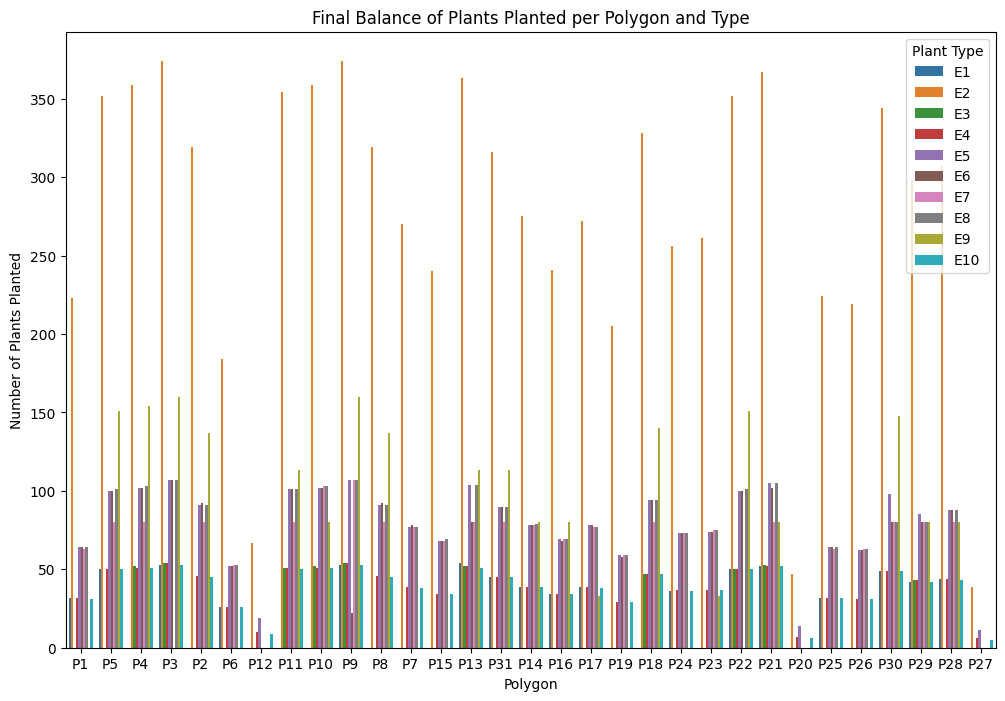

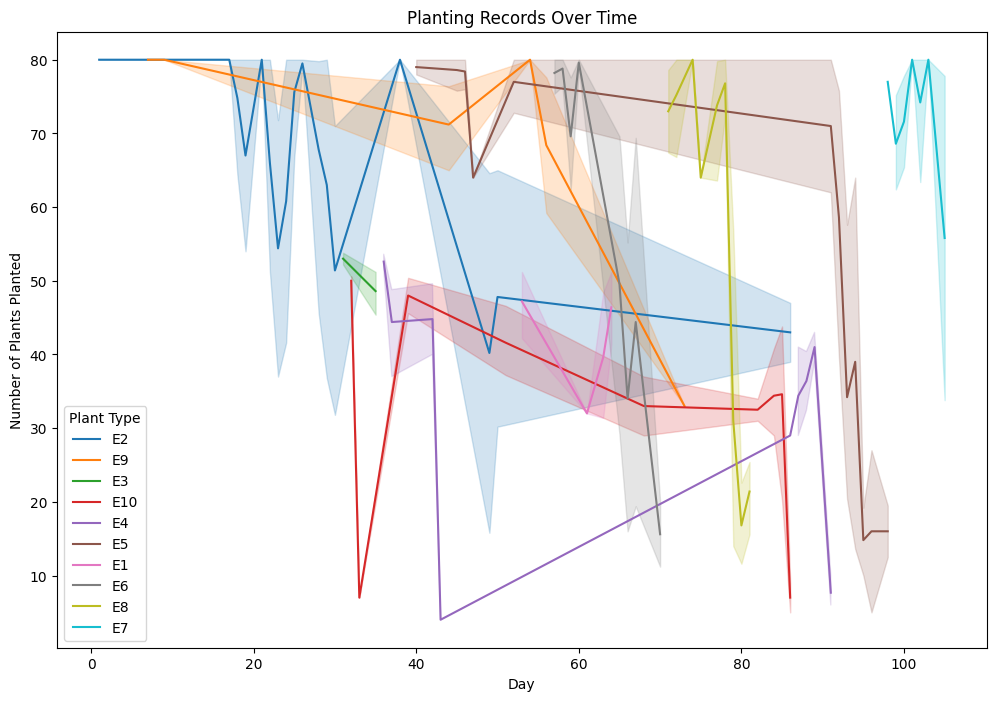

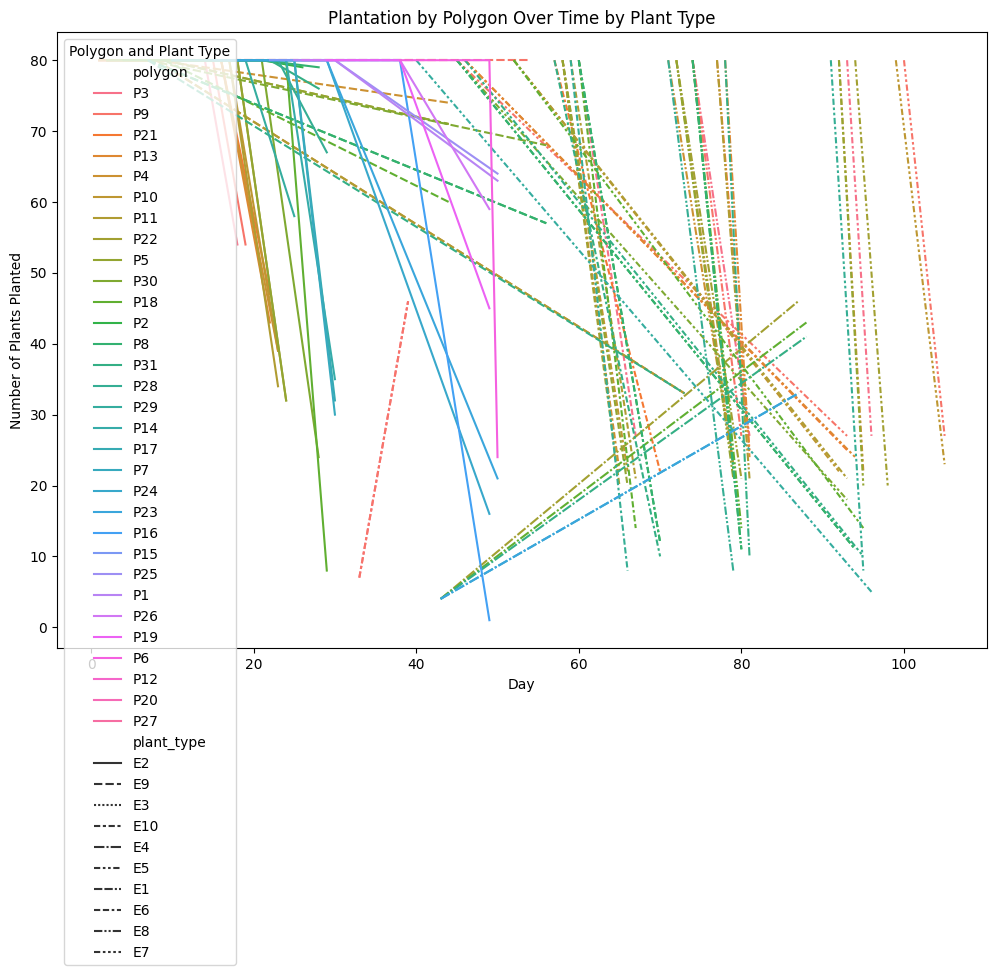

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No arrivals processed (Sunday)")
            return
        
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files and generate visualizations"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

        # Final balance of plants planted per polygon
        final_balance = []
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                final_balance.append({
                    'polygon': p,
                    'plant_type': pt,
                    'planted': planted
                })
        
        final_balance_df = pd.DataFrame(final_balance)
        final_balance_df.to_csv('final_balance.csv', index=False)
        print("Saved final balance to final_balance.csv")

        # Generate visualizations
        self.generate_visualizations()

    def generate_visualizations(self):
        """Generate visualizations for the final balance and other relevant data"""
        print("\nGenerating visualizations...")

        # Read final balance data
        final_balance_df = pd.read_csv('final_balance.csv')

        # Plot final balance of plants planted per polygon and type
        plt.figure(figsize=(12, 8))
        sns.barplot(x='polygon', y='planted', hue='plant_type', data=final_balance_df)
        plt.title('Final Balance of Plants Planted per Polygon and Type')
        plt.xlabel('Polygon')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Plant Type')
        plt.savefig('final_balance.png')
        print("Saved final balance visualization to final_balance.png")

        # Read planting records
        planting_df = pd.read_csv('heuristic_planting.csv')

        # Plot planting records over time
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='day', y='quantity', hue='plant_type', data=planting_df)
        plt.title('Planting Records Over Time')
        plt.xlabel('Day')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Plant Type')
        plt.savefig('planting_records.png')
        print("Saved planting records visualization to planting_records.png")

        # Plot plantation by polygon over time, broken down by plant type
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='day', y='quantity', hue='polygon', style='plant_type', data=planting_df)
        plt.title('Plantation by Polygon Over Time by Plant Type')
        plt.xlabel('Day')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Polygon and Plant Type')
        plt.savefig('plantation_by_polygon_over_time.png')
        print("Saved plantation by polygon over time visualization to plantation_by_polygon_over_time.png")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

# Test 3 (no planting time)

In [1]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                # Update planting minutes used (only considering delivery time)
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")




    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2:

# 15 polygons

In [5]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                            if (pt in self.survival_rates.index and
                                not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            # Ensure P18 is included and select 10 polygons
            if self.storage_polygon not in self.polygons:
                raise ValueError(f"Storage polygon {self.storage_polygon} not found in the data.")
            
            # Randomly select 9 additional polygons
            other_polygons = [p for p in self.polygons if p != self.storage_polygon]
            selected_polygons = [self.storage_polygon] + np.random.choice(other_polygons, 14, replace=False).tolist()
            
            # Filter data to include only the selected polygons
            self.distance_matrix = self.distance_matrix.loc[selected_polygons, selected_polygons]
            self.plantas_pol = self.plantas_pol[selected_polygons]
            
            self.polygons = selected_polygons
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise
        
    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                # Update planting minutes used (only considering delivery time)
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")




    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 15 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 3879 E2 plants arrived in storage
Day 1: 862 E8 plants arrived in storage
Day 1: 1659 E9 plants arrived in storage
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 1: Treated and planted 80 E2 at P18 (delivery: 60.0 mins)
Day 1: Treated and planted 80 E2 at P31 (delivery: 72.232752 mins)
Day 1: Treated and planted 80 E2 at P29 (delivery: 65.67552 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P18 (delivery: 60.0 mins)
Day 2: Treated and planted 80 E2 at P31 (delivery: 72.232752 mins)
Day 2

# 20 polygons

In [6]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                            if (pt in self.survival_rates.index and
                                not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            # Ensure P18 is included and select 10 polygons
            if self.storage_polygon not in self.polygons:
                raise ValueError(f"Storage polygon {self.storage_polygon} not found in the data.")
            
            # Randomly select 9 additional polygons
            other_polygons = [p for p in self.polygons if p != self.storage_polygon]
            selected_polygons = [self.storage_polygon] + np.random.choice(other_polygons, 19, replace=False).tolist()
            
            # Filter data to include only the selected polygons
            self.distance_matrix = self.distance_matrix.loc[selected_polygons, selected_polygons]
            self.plantas_pol = self.plantas_pol[selected_polygons]
            
            self.polygons = selected_polygons
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise
        
    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                # Update planting minutes used (only considering delivery time)
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")




    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 20 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 5430 E2 plants arrived in storage
Day 1: 970 E9 plants arrived in storage
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 2: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 2: Treated and planted 80 E2 at P4

# 25 polygons

In [7]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                            if (pt in self.survival_rates.index and
                                not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            # Ensure P18 is included and select 10 polygons
            if self.storage_polygon not in self.polygons:
                raise ValueError(f"Storage polygon {self.storage_polygon} not found in the data.")
            
            # Randomly select 9 additional polygons
            other_polygons = [p for p in self.polygons if p != self.storage_polygon]
            selected_polygons = [self.storage_polygon] + np.random.choice(other_polygons, 24, replace=False).tolist()
            
            # Filter data to include only the selected polygons
            self.distance_matrix = self.distance_matrix.loc[selected_polygons, selected_polygons]
            self.plantas_pol = self.plantas_pol[selected_polygons]
            
            self.polygons = selected_polygons
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise
        
    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                # Update planting minutes used (only considering delivery time)
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")




    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 25 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 2: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 2: Treated and planted 80 E2 at P18 (delivery: 60.0 mins)
Day 2: Total treated 

# Comparativa matematico

In [2]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                            if (pt in self.survival_rates.index and
                                not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            self.selected_polygons = ['P18', 'P17', 'P19']

            # Ensure all selected polygons exist in the original data
            for p in self.selected_polygons:
                if p not in self.polygons:
                    raise ValueError(f"Selected polygon {p} not found in the distance matrix.")

            # Filter data to include only the selected polygons
            self.distance_matrix = self.distance_matrix.loc[self.selected_polygons, self.selected_polygons]
            self.plantas_pol = self.plantas_pol[self.selected_polygons]
            self.polygons = self.selected_polygons # Update the class's polygon list
            # --- MODIFICATION END ---

            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise
        
    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            self.polygons,  # Include all polygons, including the storage polygon
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                # Update planting minutes used (only considering delivery time)
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")




    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 3 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 115 E1 plants arrived in storage
Day 1: 805 E2 plants arrived in storage
Day 1: 116 E3 plants arrived in storage
Day 1: 115 E4 plants arrived in storage
Day 1: 231 E5 plants arrived in storage
Day 1: 230 E6 plants arrived in storage
Day 1: 229 E7 plants arrived in storage
Day 1: 230 E8 plants arrived in storage
Day 1: 344 E9 plants arrived in storage
Day 1: 114 E10 plants arrived in storage
Day 1: Treated and planted 47 E1 at P18 (delivery: 60.0 mins)
Day 1: Treated and planted 39 E1 at P17 (delivery: 62.130816 mins)
Day 1: Treated and planted 29 E1 at P19 (delivery: 63.97944 mins)
Day 1: Treated and planted 47 E10 at P18 (delivery: 60.0 mins)
Day 1: Treated and planted 38 E10 at P17 (delivery: 62.130816 mins)
Day 1: Total treated and planted today: 200/1200
Storage: 2329/6400
Total planted: 200

=== Day

In [11]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            # Use the survival_rates variable from the notebook, not from CSV
            global survival_rates
            # Set index to 'Plant Type' if not already
            if survival_rates.index.name != 'Plant Type':
                survival_rates = survival_rates.set_index('Plant Type')
            # Convert columns like 'Día 3' to integers 3, 4, 5, 6
            survival_rates.columns = [int(col.replace('Día ', '')) for col in survival_rates.columns]
            self.survival_rates = survival_rates
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        # self.storage: key=plant_type, value=list of (quantity, arrival_day) tuples
        self.storage = defaultdict(list)
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        # Calculate current total plants in storage
        current_storage_qty = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage_qty
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            in_storage_this_type = sum(qty for qty, _ in self.storage[pt])
            in_transit_this_type = sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt)
            remaining_needs[pt] = max(0, remaining_needs[pt] - in_storage_this_type - in_transit_this_type)
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100 # Default to 100 if no recent plantings
        
        # --- MODIFICATION: Ordering preference based on survival rate (assuming 'Dia 3' is best) ---
        plant_types_to_order = sorted(
            [pt for pt in remaining_needs.keys() if remaining_needs[pt] > 0], 
            key=lambda pt: (remaining_needs[pt], 
                            self.survival_rates.loc[pt, 3] if 3 in self.survival_rates.columns and pt in self.survival_rates.index else 0), 
            reverse=True # Prioritize higher survival for ordering
        )
        # --- END OF MODIFICATION ---

        for pt in plant_types_to_order:
            if available_space <= 0:
                break
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for next 7 days of planting, respecting capacities
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(int(avg_daily_planting * 7 / len(self.plant_types)), self.NURSERY_TRUCK_CAPACITY) # Distribute avg_daily_planting across plant types
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        # First, remove expired plants
        self.remove_expired_plants(day)

        # Process new arrivals
        for pt in list(self.in_transit.keys()):
            new_in_transit_list = []
            arrived_today = 0
            
            for arrival_day_scheduled, plant_type, qty in self.in_transit[pt]:
                if arrival_day_scheduled == day:
                    # Check storage capacity before adding
                    current_storage_qty = sum(sum(q for q, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        self.storage[plant_type].append((qty_to_store, day)) # Store with arrival day
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # Re-add remaining quantity to in_transit for next day, if it can be stored
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty)) 
                            print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        new_in_transit_list.append((arrival_day_scheduled, plant_type, qty)) # Remains in transit
                        print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """Remove plants that have exceeded their 7-day planting window."""
        removed_count = 0
        for pt in list(self.storage.keys()):
            updated_batches = []
            for qty, arrival_day in self.storage[pt]:
                # Plants must be planted by day 7. If current day is day 7 relative to arrival_day,
                # then it's `arrival_day + 6`. If `day > arrival_day + 6`, it's expired.
                if day > (arrival_day + self.PLANTING_END_DAY - 1): # Check if current day is beyond Day 7 (arrival_day + 6)
                    removed_count += qty
                    self.total_cost += qty * self.PLANTING_COST_PER_PLANT # Cost of trashing
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired).")
                else:
                    updated_batches.append((qty, arrival_day))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Clean up if no batches left

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day.
        """
        days_since_arrival = current_day - arrival_day + 1 # +1 to make it 1-indexed (Day 1, Day 2...)
        
        # Clamp days_since_arrival to the range [PLANTING_START_DAY, PLANTING_END_DAY]
        # This handles cases where plants might be theoretically planted earlier than Dia 3
        # or on a day beyond Dia 7 (though the latter should be prevented by expiration)
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 # Default to 0 if no rate found (shouldn't happen with proper data)


    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting on Sundays.")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_plants_in_storage = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
        total_to_treat_today = min(
            total_plants_in_storage,
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat_today <= 0:
            print(f"Day {day}: No plants available in storage to treat.")
            return
        
        treated_today = 0
        
        # Create a pool of available plants, prioritized by expiration and then by *current day's* survival rate
        # Each item: (calculated_priority_score, plant_type, qty_in_batch, original_arrival_day_of_batch)
        # Priority score will combine expiration urgency and dynamic survival rate
        available_plant_pool = []
        for pt, batches in self.storage.items():
            for qty, arrival_day in batches:
                # Calculate urgency for planting this batch
                days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                
                # --- NEW: Get actual survival rate for today if planted ---
                current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                # --- END NEW ---

                # A simple priority score: higher is better.
                # Prioritize plants with fewer days left, and higher survival rates.
                # Negative days_left_to_plant means it's already past its deadline, but we try to avoid that.
                # We can use a combination: e.g., -days_left_to_plant (to prioritize lower days_left)
                # and then current_day_survival_rate (to prioritize higher survival)
                priority_score = (-days_left_to_plant, current_day_survival_rate) # Tuple for sorting
                available_plant_pool.append((priority_score, pt, qty, arrival_day))
        
        # Sort the pool:
        # 1. By ascending days_left_to_plant (prioritize expiring plants)
        # 2. By descending current_day_survival_rate (prioritize higher survival within expiration group)
        available_plant_pool.sort() # Sorts based on the tuple (first element, then second)
        
        # Iterate through the sorted plant pool to treat and plant
        for priority_score, pt, qty_in_batch, arrival_day_of_batch in available_plant_pool:
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break # Reached treatment or planting capacity
            
            # Find polygons that need this plant type, prioritized by highest survival rate if planted NOW
            polygons_with_need = []
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    # --- NEW: Use current_day_survival_rate for polygon prioritization ---
                    polygons_with_need.append((p, remaining_need, self.get_survival_rate(pt, day, arrival_day_of_batch)))
                    # --- END NEW ---
            
            # Sort polygons by descending survival rate for this plant type, then by remaining need
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant from this batch to this polygon
                plant_qty = min(
                    remaining_need_in_polygon,
                    qty_in_batch - plants_from_this_batch_planted, # Remaining from current batch
                    total_to_treat_today - treated_today,          # Remaining from treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                # Remove from storage - find the specific batch and reduce its quantity
                # We need to find the specific batch that matches the arrival_day_of_batch and plant_type
                for i, (stored_qty, stored_arrival_day) in enumerate(self.storage[pt]):
                    if stored_arrival_day == arrival_day_of_batch: # Found the correct batch
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day)
                        if self.storage[pt][i][0] <= 0: # If batch is depleted, remove it (use <=0 for safety)
                            self.storage[pt].pop(i)
                        break
                
                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate # Store the actual rate used for this planting
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}")


    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day) # This also handles expiration
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries!")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit.")
                # You might want to let it run a few more days to clear storage/transit if needed,
                # or consider the job "done" from a requirements perspective.
                # For now, we'll continue to try and clear storage/transit.

        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants available in storage to treat.
Current Storage: 0/6400
Total planted so far: 0

=== Day 1 ===
Day 1: 6400 plants arrived and stored.
Day 1: Planted 80 E2 at P3 (from batch arr. day 1, survival: 0.65, delivery: 73.998096 mins)
Day 1: Planted 80 E2 at P9 (from batch arr. day 1, survival: 0.65, delivery: 73.476912 mins)
Day 1: Planted 80 E2 at P21 (from batch arr. day 1, survival: 0.65, delivery: 66.819504 mins)
Day 1: Planted 80 E2 at P13 (from batch arr. day 1, survival: 0.65, delivery: 66.382224 mins)
Day 1: Planted 80 E2 at P4 (from batch arr. day 1, survival: 0.65, delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Current Storage: 6000/6400
Total planted so far: 400

=== Day 2 ===
Day 2: Planted 80 E2 at P10 (from batch arr. day 1, survival: 0.65, delivery: 74.46091200000001 mins)
Day 2: Planted 80 E2 at P11 (from batch arr. day 1, surviva

In [14]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival (inclusive)
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        # self.storage: key=plant_type, value=list of (quantity, arrival_day) tuples
        self.storage = defaultdict(list)
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage_qty = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage_qty
        
        if available_space <= 0:
            return
        
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        for pt in self.plant_types:
            in_storage_this_type = sum(qty for qty, _ in self.storage[pt])
            in_transit_this_type = sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt)
            remaining_needs[pt] = max(0, remaining_needs[pt] - in_storage_this_type - in_transit_this_type)
        
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100 
        
        plant_types_to_order = sorted(
            [pt for pt in remaining_needs.keys() if remaining_needs[pt] > 0], 
            key=lambda pt: (remaining_needs[pt], 
                            self.survival_rates.loc[pt, self.PLANTING_START_DAY] if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0), 
            reverse=True 
        )

        for pt in plant_types_to_order:
            if available_space <= 0:
                break
                
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(int(avg_daily_planting * 7 / len(self.plant_types)), self.NURSERY_TRUCK_CAPACITY) 
            )
            
            if order_qty <= 0:
                continue
                
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        # First, remove expired plants
        self.remove_expired_plants(day)

        # Process new arrivals
        for pt in list(self.in_transit.keys()):
            new_in_transit_list = []
            arrived_today = 0
            
            for arrival_day_scheduled, plant_type, qty in self.in_transit[pt]:
                if arrival_day_scheduled == day:
                    current_storage_qty = sum(sum(q for q, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        self.storage[plant_type].append((qty_to_store, day)) # Store with arrival day
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty)) 
                            print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        new_in_transit_list.append((arrival_day_scheduled, plant_type, qty)) # Remains in transit
                        print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """Remove plants that have exceeded their 7-day planting window (i.e., not planted by Day 7)."""
        removed_count = 0
        for pt in list(self.storage.keys()):
            updated_batches = []
            for qty, arrival_day in self.storage[pt]:
                # Calculate the last possible day to plant (arrival_day + 6)
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: 
                    removed_count += qty
                    self.total_cost += qty * self.PLANTING_COST_PER_PLANT # Cost of trashing
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired).")
                else:
                    updated_batches.append((qty, arrival_day))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Clean up if no batches left

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # +1 to make it 1-indexed (Day 1, Day 2...)
        
        # Check if the plant is within the valid planting window (Day 3 to Day 7)
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 # Cannot plant, or outside valid window, so survival rate is effectively zero for this decision
        
        # Clamp days_since_arrival to the range [PLANTING_START_DAY, PLANTING_END_DAY]
        # This handles cases where plants might be theoretically planted earlier than Dia 3
        # or on a day beyond Dia 7 (though the latter should be prevented by expiration)
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 


    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting on Sundays.")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Create a pool of *eligible* available plants based on the 3-7 day rule
        eligible_plant_pool = []
        for pt, batches in self.storage.items():
            for qty, arrival_day in batches:
                days_since_arrival = day - arrival_day + 1
                
                # Check if this batch is eligible to be planted TODAY
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    # Only add to pool if it has a non-zero survival rate (i.e., eligible)
                    if current_day_survival_rate > 0:
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        # A simple priority score: higher is better.
                        # Prioritize plants with fewer days left, and higher survival rates.
                        priority_score = (-days_left_to_plant, -current_day_survival_rate) # Sort by (urgency, -survival_rate)
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day))
        
        # Sort the eligible pool:
        # 1. By ascending days_left_to_plant (prioritize expiring plants)
        # 2. By descending current_day_survival_rate (prioritize higher survival within expiration group)
        eligible_plant_pool.sort() 
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Sum of quantities in eligible batches
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat_today <= 0:
            print(f"Day {day}: No eligible plants available in storage to treat.")
            return
        
        treated_today = 0
        
        # Iterate through the sorted eligible plant pool to treat and plant
        for priority_score, pt, qty_in_batch, arrival_day_of_batch in eligible_plant_pool:
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break # Reached treatment or planting capacity
            
            # Find polygons that need this plant type, prioritized by highest survival rate if planted NOW
            polygons_with_need = []
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: # Only consider if it can actually survive
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                plant_qty = min(
                    remaining_need_in_polygon,
                    qty_in_batch - plants_from_this_batch_planted, 
                    total_to_treat_today - treated_today,          
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                for i, (stored_qty, stored_arrival_day) in enumerate(self.storage[pt]):
                    if stored_arrival_day == arrival_day_of_batch: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day)
                        if self.storage[pt][i][0] <= 0: 
                            self.storage[pt].pop(i)
                        break
                
                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}")


    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) 
            self.order_plants(day)
            self.treat_and_plant_plants(day)  
            
            current_storage_qty = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries!")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit.")

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No eligible plants available in storage to treat.
Current Storage: 0/6400
Total planted so far: 0

=== Day 1 ===
Day 1: 6400 plants arrived and stored.
Day 1: No eligible plants available in storage to treat.
Current Storage: 6400/6400
Total planted so far: 0

=== Day 2 ===
Day 2: No eligible plants available in storage to treat.
Current Storage: 6400/6400
Total planted so far: 0

=== Day 3 ===
Day 3: Planted 80 E2 at P3 (from batch arr. day 1, survival: 0.65, delivery: 73.998096 mins)
Day 3: Planted 80 E2 at P9 (from batch arr. day 1, survival: 0.65, delivery: 73.476912 mins)
Day 3: Planted 80 E2 at P21 (from batch arr. day 1, survival: 0.65, delivery: 66.819504 mins)
Day 3: Planted 80 E2 at P13 (from batch arr. day 1, survival: 0.65, delivery: 66.382224 mins)
Day 3: Planted 80 E2 at P4 (from batch arr. day 1, survival: 0.65, delivery: 74.982096 mins)
Day 3: Total treated an

In [17]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival (inclusive)
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        # self.storage: key=plant_type, value=list of (quantity, arrival_day) tuples
        self.storage = defaultdict(list)
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # New counter for trashed plants

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to minimize trashed plants and maintain workflow."""
        current_total_plants_in_storage = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return
        
        remaining_needs_total = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs_total[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Calculate currently available and in-transit plants
        current_and_in_transit_qty = defaultdict(int)
        for pt in self.plant_types:
            current_and_in_transit_qty[pt] += sum(qty for qty, _ in self.storage[pt])
            current_and_in_transit_qty[pt] += sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt)

        # Estimate future planting capacity over the lead time + planting window
        # We need to consider how many plants we can *actually* plant from order arrival to expiration
        # For simplicity, let's estimate daily planting capacity
        max_daily_planting_capacity = min(self.TREATMENT_CAPACITY, self.DELIVERY_TRUCK_CAPACITY * len(self.polygons)) # A rough upper bound
        
        # Look ahead window for ordering: from order arrival to when they must be planted
        look_ahead_days = self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - self.PLANTING_START_DAY + 1)
        
        # How many plants do we expect to plant in the next 'look_ahead_days' that are NOT yet covered?
        # This is a critical estimation to avoid over-ordering.
        # We need to account for what's already in storage that *will become* plantable.
        expected_demand_in_window = defaultdict(int)
        for pt in self.plant_types:
            # How many plants of this type could we potentially plant in the next `look_ahead_days`?
            # Max plants that can be planted in the window, limited by demand.
            estimated_plantable_in_window = 0
            for d_offset in range(self.ORDER_LEAD_TIME, look_ahead_days): # Days relative to today for future arrival
                # We can't know exact future planting capacity, so estimate it.
                # A simple estimate: max daily planting capacity, distributed across types or focused on needs.
                estimated_plantable_in_window += max_daily_planting_capacity / len(self.plant_types) # Distribute it
            
            # The net amount we might need to order for this window
            net_need_for_window = max(0, estimated_plantable_in_window - current_and_in_transit_qty[pt])
            expected_demand_in_window[pt] = min(net_need_for_window, remaining_needs_total[pt])
        
        # Sort plants to order:
        # 1. By how much is needed in the look-ahead window (descending)
        # 2. By highest survival rate for their earliest planting day (Dia 3, descending)
        # 3. By cheapest nursery cost (ascending) to minimize initial outlay
        plant_types_to_order = []
        for pt in self.plant_types:
            if expected_demand_in_window[pt] > 0:
                best_nursery = None
                best_cost = float('inf')
                for n in self.nurseries:
                    cost = self.nursery_costs[n].get(pt, 99999)
                    if cost < best_cost:
                        best_nursery = n
                        best_cost = cost
                
                if best_nursery is not None:
                    survival_rate_at_start = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                        if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0
                    plant_types_to_order.append((expected_demand_in_window[pt], 
                                                survival_rate_at_start, 
                                                best_cost, 
                                                pt, 
                                                best_nursery))
        
        # Sort by: (negative demand in window for descending), (negative survival rate for descending), (cost for ascending)
        plant_types_to_order.sort(key=lambda x: (-x[0], -x[1], x[2]))

        for demand_in_window, survival_rate, nursery_cost, pt, best_nursery in plant_types_to_order:
            if available_space <= 0:
                break
                
            # Order quantity:
            # - No more than the estimated demand for this plant type in the look-ahead window.
            # - No more than what the truck can carry.
            # - No more than available storage space.
            order_qty = min(
                demand_in_window,
                self.NURSERY_TRUCK_CAPACITY,
                available_space
            )
            
            # Ensure we order a meaningful quantity, perhaps at least one full truck if demand is high.
            # This balances minimizing trash with ensuring steady supply.
            if order_qty < self.NURSERY_TRUCK_CAPACITY and demand_in_window > self.NURSERY_TRUCK_CAPACITY * 0.5:
                order_qty = self.NURSERY_TRUCK_CAPACITY # Try to fill a truck if there's significant demand
            
            if order_qty <= 0:
                continue
                
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * nursery_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty
            print(f"Day {day}: Ordered {order_qty} {pt} from {best_nursery} for arrival Day {day + self.ORDER_LEAD_TIME}")

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        # First, remove expired plants
        self.remove_expired_plants(day)

        # Process new arrivals
        for pt in list(self.in_transit.keys()):
            new_in_transit_list = []
            arrived_today = 0
            
            # Sort in-transit items by scheduled arrival day for consistency (though it should generally be sequential)
            self.in_transit[pt].sort(key=lambda x: x[0])

            for arrival_day_scheduled, plant_type, qty in self.in_transit[pt]:
                if arrival_day_scheduled == day:
                    current_storage_qty = sum(sum(q for q, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        self.storage[plant_type].append((qty_to_store, day)) # Store with arrival day
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If partial delivery due to storage, remaining qty attempts arrival *tomorrow*
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty)) 
                            print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If storage full, the entire quantity attempts arrival *tomorrow*
                        new_in_transit_list.append((day + 1, plant_type, qty)) 
                        print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """Remove plants that have exceeded their 7-day planting window (i.e., not planted by Day 7)."""
        removed_count = 0
        for pt in list(self.storage.keys()):
            updated_batches = []
            for qty, arrival_day in self.storage[pt]:
                # Calculate the last possible day to plant (arrival_day + 6)
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: 
                    removed_count += qty
                    self.total_cost += qty * self.PLANTING_COST_PER_PLANT # Cost of trashing
                    self.trashed_plants_count += qty # Increment trashed plants counter
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired).")
                else:
                    updated_batches.append((qty, arrival_day))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Clean up if no batches left

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # +1 to make it 1-indexed (Day 1, Day 2...)
        
        # Check if the plant is within the valid planting window (Day 3 to Day 7)
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 # Cannot plant, or outside valid window, so survival rate is effectively zero for this decision
        
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 


    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting on Sundays.")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Create a pool of *eligible* available plants based on the 3-7 day rule
        eligible_plant_pool = []
        for pt, batches in self.storage.items():
            for qty, arrival_day in batches:
                days_since_arrival = day - arrival_day + 1
                
                # Check if this batch is eligible to be planted TODAY
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: # Only add to pool if it has a non-zero survival rate (i.e., eligible)
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        priority_score = (-days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day))
        
        eligible_plant_pool.sort() 
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) 
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat_today <= 0:
            print(f"Day {day}: No eligible plants available in storage to treat.")
            return
        
        treated_today = 0
        
        for priority_score, pt, qty_in_batch, arrival_day_of_batch in eligible_plant_pool:
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = []
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                plant_qty = min(
                    remaining_need_in_polygon,
                    qty_in_batch - plants_from_this_batch_planted, 
                    total_to_treat_today - treated_today,          
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                for i, (stored_qty, stored_arrival_day) in enumerate(self.storage[pt]):
                    if stored_arrival_day == arrival_day_of_batch: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day)
                        if self.storage[pt][i][0] <= 0: 
                            self.storage[pt].pop(i)
                        break
                
                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}")


    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) 
            self.order_plants(day)
            self.treat_and_plant_plants(day)  
            
            current_storage_qty = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}") # Display trashed plants
            
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries!")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit.")

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") # Final report for trashed plants
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count # Include trashed plants in summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: Ordered 600.0 E2 from V4 for arrival Day 1
Day 0: Ordered 600.0 E1 from V4 for arrival Day 1
Day 0: Ordered 600.0 E3 from V2 for arrival Day 1
Day 0: Ordered 600.0 E4 from V3 for arrival Day 1
Day 0: Ordered 600.0 E7 from V2 for arrival Day 1
Day 0: Ordered 600.0 E10 from V1 for arrival Day 1
Day 0: Ordered 600.0 E8 from V3 for arrival Day 1
Day 0: Ordered 600.0 E6 from V3 for arrival Day 1
Day 0: Ordered 600.0 E5 from V2 for arrival Day 1
Day 0: Ordered 600.0 E9 from V1 for arrival Day 1
Day 0: No eligible plants available in storage to treat.
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 600.0 plants arrived and stored.
Day 1: 600.0 plants arrived and stored.
Day 1: 600.0 plants arrived and stored.
Day 1: 600.0 plants arrived and stored.
Day 1: 600.0 plants arrived and stored.
Day 1: 600.0 plants arrived and stored.
Day 1: 600

In [16]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant (also used for trashing penalty)
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival (inclusive)
        self.DAYS = 225
        self.PENALTY_TRASHED_PLANT = self.PLANTING_COST_PER_PLANT # Cost per plant if trashed

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty)
        
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """Estimate the maximum number of plants that can be planted on a given day."""
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        # Max plants handled by treatment capacity
        capacity_by_treatment = self.TREATMENT_CAPACITY
        
        # Max plants that can be planted by crews
        # Assuming crews can plant PLANTS_PER_HOUR * WORK_HOURS per day.
        # This is simplified; real capacity depends on polygon distances and available trucks.
        # Let's take a conservative estimate based on total work capacity available
        capacity_by_crews = self.PLANTS_PER_HOUR * work_hours * len(self.polygons) # Rough upper bound assuming many crews/trucks
        
        # However, the true bottleneck might be the number of delivery trucks and their capacity
        # Let's assume we have enough delivery trucks to meet treatment capacity up to a reasonable point.
        # For simplicity, we'll primarily be bottlenecked by TREATMENT_CAPACITY.
        return min(capacity_by_treatment, capacity_by_crews) # Or choose the primary bottleneck if known

    def order_plants(self, day):
        """
        Orders plants strictly based on forecasted need to minimize trashing,
        considering current stock, in-transit, and future planting capacity.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            return
        
        # 1. Calculate total remaining requirements per plant type
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)

        # 2. Forecast plantable supply over the critical window
        # Critical window: from order arrival (day + ORDER_LEAD_TIME) to max planting day (day + ORDER_LEAD_TIME + 6)
        # We need to assess how many plants of each type will become plantable and can be planted
        # within this window, considering existing stock and in-transit.
        
        forecast_horizon_end_day = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) # Last day a new order can be planted
        
        plantable_supply_in_future = defaultdict(int) # Plants from current storage/in-transit that will be plantable
        
        # Consider plants already in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day in batches:
                # Iterate through potential planting days for this batch
                for future_planting_day in range(day + 1, forecast_horizon_end_day + 1):
                    days_since_arrival = future_planting_day - arrival_day + 1
                    if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                        # This batch will be plantable on future_planting_day
                        # We are assuming it contributes to the overall plantable supply.
                        # This sum can overcount if a plant is plantable for multiple days,
                        # but it's a proxy for total potential supply in the window.
                        plantable_supply_in_future[pt] += qty 
                        break # Only count once per batch if it becomes plantable within window

        # Consider plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, _, qty in self.in_transit[pt]:
                if arrival_day_scheduled <= forecast_horizon_end_day: # If it arrives within our forecast window
                    # Assume it will be plantable as soon as it hits Day 3 after arrival
                    future_plantable_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                    if future_plantable_day <= forecast_horizon_end_day:
                         plantable_supply_in_future[pt] += qty
        
        # 3. Calculate the net quantity to order
        # What we need = total requirements - (existing plantable + incoming plantable)
        plants_to_order_candidate = defaultdict(int)
        for pt in self.plant_types:
            needed = total_remaining_requirements[pt] - plantable_supply_in_future[pt]
            if needed > 0:
                plants_to_order_candidate[pt] = needed

        # 4. Prioritize orders based on cost and survival rate for 'Dia 3'
        orders_to_place = []
        for pt, needed_qty in plants_to_order_candidate.items():
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is not None:
                survival_rate_at_start = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                    if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0
                
                orders_to_place.append({
                    'plant_type': pt,
                    'needed_qty': needed_qty,
                    'nursery': best_nursery,
                    'cost': best_cost,
                    'survival_rate': survival_rate_at_start
                })
        
        # Sort by (negative survival rate for descending), then (cost for ascending)
        orders_to_place.sort(key=lambda x: (-x['survival_rate'], x['cost']))

        # 5. Place orders, respecting capacities strictly
        for order_info in orders_to_place:
            if available_storage_space <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            nursery_cost = order_info['cost']
            qty_needed_for_type = order_info['needed_qty']

            # Order quantity strictly limited by what's needed, truck capacity, and storage space
            order_qty = min(
                qty_needed_for_type,
                self.NURSERY_TRUCK_CAPACITY,
                available_storage_space
            )
            
            if order_qty <= 0:
                continue
            
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * nursery_cost + self.NURSERY_TRUCK_COST
            available_storage_space -= order_qty
            print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME}")

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        # First, remove expired plants
        self.remove_expired_plants(day)

        # Process new arrivals
        for pt in list(self.in_transit.keys()):
            new_in_transit_list = []
            arrived_today = 0
            
            self.in_transit[pt].sort(key=lambda x: x[0]) # Sort by scheduled arrival day

            for arrival_day_scheduled, plant_type, qty in self.in_transit[pt]:
                if arrival_day_scheduled == day:
                    current_storage_qty = sum(sum(q for q, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        self.storage[plant_type].append((qty_to_store, day)) # Store with arrival day
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty)) 
                            print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        new_in_transit_list.append((day + 1, plant_type, qty)) 
                        print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """Remove plants that have exceeded their 7-day planting window (i.e., not planted by Day 7)."""
        removed_count = 0
        for pt in list(self.storage.keys()):
            updated_batches = []
            for qty, arrival_day in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: 
                    removed_count += qty
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT # Penalize trashed plants
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired).")
                else:
                    updated_batches.append((qty, arrival_day))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] 

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 
        
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 
        
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 


    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting on Sundays.")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = []
        for pt, batches in self.storage.items():
            for qty, arrival_day in batches:
                days_since_arrival = day - arrival_day + 1
                
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: 
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        priority_score = (-days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day))
        
        eligible_plant_pool.sort() 
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) 
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat_today <= 0:
            print(f"Day {day}: No eligible plants available in storage to treat.")
            return
        
        treated_today = 0
        
        for priority_score, pt, qty_in_batch, arrival_day_of_batch in eligible_plant_pool:
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = []
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                plant_qty = min(
                    remaining_need_in_polygon,
                    qty_in_batch - plants_from_this_batch_planted, 
                    total_to_treat_today - treated_today,          
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                for i, (stored_qty, stored_arrival_day) in enumerate(self.storage[pt]):
                    if stored_arrival_day == arrival_day_of_batch: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day)
                        if self.storage[pt][i][0] <= 0: 
                            self.storage[pt].pop(i)
                        break
                
                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}")


    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) 
            self.order_plants(day)
            self.treat_and_plant_plants(day)  
            
            current_storage_qty = sum(sum(qty for qty, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries!")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit.")
                # We can break here if the only goal is to meet requirements and cost-min trashing
                # But letting it run can allow for clearing remaining storage. Depends on objective.
                # For strict "minimize trashed", we should stop ordering and let existing clear.
                # The current order_plants will naturally stop ordering if requirements are met.
                pass # Continue to try and clear storage/transit if requirements are met early.

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count 
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: Ordered 6400 E2 from V4 for arrival Day 1
Day 0: No eligible plants available in storage to treat.
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 6400 plants arrived and stored.
Day 1: No eligible plants available in storage to treat.
Current Storage: 6400/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: No eligible plants available in storage to treat.
Current Storage: 6400/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: Planted 80 E2 at P3 (from batch arr. day 1, survival: 0.65, delivery: 73.998096 mins)
Day 3: Planted 80 E2 at P9 (from batch arr. day 1, survival: 0.65, delivery: 73.476912 mins)
Day 3: Planted 80 E2 at P21 (from batch arr. day 1, survival: 0.65, delivery: 66.819504 mins)
Day 3: Planted 80 E2 at P13 (from batch arr. day 1, survival: 0.65, delivery: 66.382224 m

In [20]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # Get the survival rate for a newly arrived plant (using Day 3 rate)
            survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            
            if survival_rate_for_new_order <= 0.0: 
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order,
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 
        
        # Ensure the 'planting_day_key' is within the valid range of survival_rates columns
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 # Return 0 if survival rate data is missing for some reason


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration and polygons with high need/survival.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: # Only consider plants with a positive survival rate
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent) then higher 'survival_rate'
                        priority_score = (days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost))
        
        eligible_plant_pool.sort() # Sorts the pool based on the priority_score (ascending)
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need, current_survival_rate)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            # Sort polygons by survival rate (higher first), then quantity needed (more first)
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.


        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count 
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 2426 plants arrived and stored.
Day 1: 874 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
Day 4: 600 plants arrived and stored.
Day 4: Total treated and planted today: 400/1200.
Current Storage: 4900/6400
Total planted so far: 800
Total trashed plants: 0

=== Day 5 ===
Day 5: 200 plants arrived and stored.
Day 5: 400 plants arrived and stored.
Day 5: Total treated and planted today: 160/1200.
Current Storage: 5340/640

In [21]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # Get the survival rate for a newly arrived plant (using Day 3 rate)
            survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            
            if survival_rate_for_new_order <= 0.0: 
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order,
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 
        
        # Ensure the 'planting_day_key' is within the valid range of survival_rates columns
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 # Return 0 if survival rate data is missing for some reason


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration and polygons with high need/survival.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: # Only consider plants with a positive survival rate
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent) then higher 'survival_rate'
                        priority_score = (days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost))
        
        eligible_plant_pool.sort() # Sorts the pool based on the priority_score (ascending)
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need, current_survival_rate)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            # Sort polygons by survival rate (higher first), then quantity needed (more first)
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Update for average survival rate calculation
                self.total_expected_survivors += plant_qty * polygon_survival_rate
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 2426 plants arrived and stored.
Day 1: 874 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
Day 4: 600 plants arrived and stored.
Day 4: Total treated and planted today: 400/1200.
Current Storage: 4900/6400
Total planted so far: 800
Total trashed plants: 0

=== Day 5 ===
Day 5: 200 plants arrived and stored.
Day 5: 400 plants arrived and stored.
Day 5: Total treated and planted today: 160/1200.
Current Storage: 5340/640

# Trash

In [1]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # Get the survival rate for a newly arrived plant (using Day 3 rate)
            survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            
            if survival_rate_for_new_order <= 0.0: 
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order,
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 
        
        # Ensure the 'planting_day_key' is within the valid range of survival_rates columns
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 # Return 0 if survival rate data is missing for some reason


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration and polygons with high need/survival.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: # Only consider plants with a positive survival rate
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent) then higher 'survival_rate'
                        priority_score = (days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost))
        
        eligible_plant_pool.sort() # Sorts the pool based on the priority_score (ascending)
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need, current_survival_rate)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            # Sort polygons by survival rate (higher first), then quantity needed (more first)
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Update for average survival rate calculation
                self.total_expected_survivors += plant_qty * polygon_survival_rate
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 2426 plants arrived and stored.
Day 1: 874 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
Day 4: 600 plants arrived and stored.
Day 4: Total treated and planted today: 400/1200.
Current Storage: 4900/6400
Total planted so far: 800
Total trashed plants: 0

=== Day 5 ===
Day 5: 200 plants arrived and stored.
Day 5: 400 plants arrived and stored.
Day 5: Total treated and planted today: 160/1200.
Current Storage: 5340/640

# 3 polygons

In [10]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Define the specific polygons for this test
            # THIS IS THE CHANGE: Filter polygons to only P17, P18, P19
            self.polygons = ['P4', 'P18', 'P9','P10'] 
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            
            # Filter distance_matrix and plantas_pol based on the selected polygons
            self.distance_matrix = self.distance_matrix.loc[self.polygons, self.polygons]
            self.plantas_pol = self.plantas_pol[self.polygons]

            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # Get the survival rate for a newly arrived plant (using Day 3 rate)
            survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            
            if survival_rate_for_new_order <= 0.0: 
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order,
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 
        
        # Ensure the 'planting_day_key' is within the valid range of survival_rates columns
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 # Return 0 if survival rate data is missing for some reason


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration and polygons with high need/survival.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: # Only consider plants with a positive survival rate
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent) then higher 'survival_rate'
                        priority_score = (days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost))
        
        eligible_plant_pool.sort() # Sorts the pool based on the priority_score (ascending)
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need, current_survival_rate)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            # Sort polygons by survival rate (higher first), then quantity needed (more first)
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Update for average survival rate calculation
                self.total_expected_survivors += plant_qty * polygon_survival_rate
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 4 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 54 plants arrived and stored.
Day 1: 1420 plants arrived and stored.
Day 1: 203 plants arrived and stored.
Day 1: 405 plants arrived and stored.
Day 1: 405 plants arrived and stored.
Day 1: 406 plants arrived and stored.
Day 1: 407 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 373/1200.
Current Storage: 4727/6400
Total planted so far: 373
Total trashed plants: 0

=== Day 4 ===
Day 4: 220 plants arrived and stored.
Day 4: 380 plants arrived and stored.
Day 4: Total treated and planted today: 321/1200.
Current Storage: 

# TEST

In [4]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 # Increased significantly

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # Get the survival rate for a newly arrived plant (using Day 3 rate)
            survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
                if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            
            if survival_rate_for_new_order <= 0.0: 
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order,
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day. Returns 0.0 if not within valid planting window.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 
        
        # Ensure the 'planting_day_key' is within the valid range of survival_rates columns
        planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        
        if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
            return self.survival_rates.loc[plant_type, planting_day_key]
        return 0.0 # Return 0 if survival rate data is missing for some reason


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration and polygons with high need/survival.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    current_day_survival_rate = self.get_survival_rate(pt, day, arrival_day)
                    
                    if current_day_survival_rate > 0: # Only consider plants with a positive survival rate
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent) then higher 'survival_rate'
                        priority_score = (days_left_to_plant, -current_day_survival_rate) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost))
        
        eligible_plant_pool.sort() # Sorts the pool based on the priority_score (ascending)
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need, current_survival_rate)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    current_polygon_survival_rate = self.get_survival_rate(pt, day, arrival_day_of_batch)
                    if current_polygon_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, current_polygon_survival_rate))
            
            # Sort polygons by survival rate (higher first), then quantity needed (more first)
            polygons_with_need.sort(key=lambda x: (x[2], x[1]), reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_survival_rate in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_survival_rate 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Update for average survival rate calculation
                self.total_expected_survivors += plant_qty * polygon_survival_rate
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_survival_rate:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 2426 plants arrived and stored.
Day 1: 874 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
Day 4: 600 plants arrived and stored.
Day 4: Total treated and planted today: 400/1200.
Current Storage: 4900/6400
Total planted so far: 800
Total trashed plants: 0

=== Day 5 ===
Day 5: 200 plants arrived and stored.
Day 5: 400 plants arrived and stored.
Day 5: Total treated and planted today: 160/1200.
Current Storage: 5340/640

# No survival rate

In [11]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 # Increased significantly

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        Survival rate is ignored for ordering decisions in this version.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # --- MODIFIED: Survival rate is ignored for ordering decisions ---
            survival_rate_for_new_order = 1.0 # Assume 100% survival for decision-making
            # Original line (commented out):
            # survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
            #     if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            # ---------------------------------------------------------------
            
            if survival_rate_for_new_order <= 0.0: # Still check, just in case (though it will always be 1.0 here)
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            # --- MODIFIED: Division by 1.0 (survival_rate_for_new_order) changes nothing ---
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order
            # --------------------------------------------------------------------------------

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order, # This will be 1.0 for decision-making
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${best_base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day.
        
        MODIFIED: Returns 1.0 (100%) if within planting window, otherwise 0.0.
        The actual survival_rates data is ignored for decision-making but will be used for final reporting.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 # Plant cannot be planted, effectively 0% survival
        
        # --- MODIFIED: Always return 1.0 if within planting window ---
        # The original line below would return the actual survival rate from the data:
        # planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        # if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
        #    return self.survival_rates.loc[plant_type, planting_day_key]
        return 1.0 # Assume 100% survival for decision-making purposes when plantable
        # -------------------------------------------------------------


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration. Survival rate is ignored for prioritization.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    # Retrieve the *actual* survival rate for reporting later, but not for decision making here
                    survival_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
                    if pt in self.survival_rates.index and survival_day_key in self.survival_rates.columns:
                        actual_current_day_survival_rate = self.survival_rates.loc[pt, survival_day_key]
                    else:
                        actual_current_day_survival_rate = 0.0

                    if actual_current_day_survival_rate > 0: # Still only consider if it has a chance to survive in reality
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent)
                        # --- MODIFIED: Removed survival rate from priority score ---
                        priority_score = (days_left_to_plant, ) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost, actual_current_day_survival_rate))
        
        # Sorts the pool based on the priority_score (ascending for days_left_to_plant)
        # Note: If two plants have the same days_left_to_plant, their relative order is stable (FIFO-ish based on input order)
        eligible_plant_pool.sort() 
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost, actual_survival_rate_for_record in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    # We still check if the *actual* survival rate for this polygon/plant type is > 0 for this day.
                    # This prevents trying to plant where it's truly impossible to survive.
                    polygon_actual_survival_rate = self.survival_rates.loc[pt, max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, day - arrival_day_of_batch + 1))] \
                        if pt in self.survival_rates.index and max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, day - arrival_day_of_batch + 1)) in self.survival_rates.columns else 0.0

                    if polygon_actual_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, polygon_actual_survival_rate)) # Pass actual survival for recording
            
            # Sort polygons by quantity needed (more first), as survival rate is not a factor for decision-making
            # We explicitly *do not* sort by the actual_survival_rate here for decision purposes.
            polygons_with_need.sort(key=lambda x: x[1], reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_actual_survival_rate_for_record in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event, using the actual survival rate for the record
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_actual_survival_rate_for_record 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Update for average survival rate calculation using the ACTUAL survival rate
                self.total_expected_survivors += plant_qty * polygon_actual_survival_rate_for_record
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_actual_survival_rate_for_record:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 2427 plants arrived and stored.
Day 1: 873 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
Day 4: 600 plants arrived and stored.
Day 4: Total treated and planted today: 400/1200.
Current Storage: 4900/6400
Total planted so far: 800
Total trashed plants: 0

=== Day 5 ===
Day 5: 200 plants arrived and stored.
Day 5: 400 plants arrived and stored.
Day 5: Total treated and planted today: 160/1200.
Current Storage: 5340/640

# 15 polygons

In [26]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np
import random # Import the random module

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 # Increased significantly

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']

            # --- MODIFICATION START ---
            all_available_polygons = self.distance_matrix.index.tolist()
            
            # Ensure 'P18' is in the list of all available polygons
            if self.storage_polygon not in all_available_polygons:
                raise ValueError(f"Storage polygon '{self.storage_polygon}' not found in distance matrix index.")

            # Remove 'P18' from the pool for random selection to avoid duplication
            selectable_polygons = [p for p in all_available_polygons if p != self.storage_polygon]
            
            # Determine how many more polygons are needed (15 total - 1 for P18)
            num_additional_polygons = 25 - 1 

            # Select 14 random polygons (or fewer if not enough available)
            # Use min to ensure we don't try to select more than available
            selected_random_polygons = random.sample(selectable_polygons, min(num_additional_polygons, len(selectable_polygons)))
            
            # Combine 'P18' with the randomly selected polygons
            self.polygons = [self.storage_polygon] + selected_random_polygons
            # --- MODIFICATION END ---
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.polygons:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        Survival rate is ignored for ordering decisions in this version.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # --- MODIFIED: Survival rate is ignored for ordering decisions ---
            survival_rate_for_new_order = 1.0 # Assume 100% survival for decision-making
            # Original line (commented out):
            # survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
            #     if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            # ---------------------------------------------------------------
            
            if survival_rate_for_new_order <= 0.0: # Still check, just in case (though it will always be 1.0 here)
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            # --- MODIFIED: Division by 1.0 (survival_rate_for_new_order) changes nothing ---
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order
            # --------------------------------------------------------------------------------

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order, # This will be 1.0 for decision-making
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${best_base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day.
        
        MODIFIED: Returns 1.0 (100%) if within planting window, otherwise 0.0.
        The actual survival_rates data is ignored for decision-making but will be used for final reporting.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 # Plant cannot be planted, effectively 0% survival
        
        # --- MODIFIED: Always return 1.0 if within planting window ---
        # The original line below would return the actual survival rate from the data:
        # planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        # if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
        #    return self.survival_rates.loc[plant_type, planting_day_key]
        return 1.0 # Assume 100% survival for decision-making purposes when plantable
        # -------------------------------------------------------------


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration. Survival rate is ignored for prioritization.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    # Retrieve the *actual* survival rate for reporting later, but not for decision making here
                    survival_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
                    if pt in self.survival_rates.index and survival_day_key in self.survival_rates.columns:
                        actual_current_day_survival_rate = self.survival_rates.loc[pt, survival_day_key]
                    else:
                        actual_current_day_survival_rate = 0.0

                    if actual_current_day_survival_rate > 0: # Still only consider if it has a chance to survive in reality
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent)
                        # --- MODIFIED: Removed survival rate from priority score ---
                        priority_score = (days_left_to_plant, ) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost, actual_current_day_survival_rate))
        
        # Sorts the pool based on the priority_score (ascending for days_left_to_plant)
        # Note: If two plants have the same days_left_to_plant, their relative order is stable (FIFO-ish based on input order)
        eligible_plant_pool.sort() 
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost, actual_survival_rate_for_record in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    # We still check if the *actual* survival rate for this polygon/plant type is > 0 for this day.
                    # This prevents trying to plant where it's truly impossible to survive.
                    polygon_actual_survival_rate = self.survival_rates.loc[pt, max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, day - arrival_day_of_batch + 1))] \
                        if pt in self.survival_rates.index and max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, day - arrival_day_of_batch + 1)) in self.survival_rates.columns else 0.0

                    if polygon_actual_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, polygon_actual_survival_rate)) # Pass actual survival for recording
            
            # Sort polygons by quantity needed (more first), as survival rate is not a factor for decision-making
            # We explicitly *do not* sort by the actual_survival_rate here for decision purposes.
            polygons_with_need.sort(key=lambda x: x[1], reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_actual_survival_rate_for_record in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event, using the actual survival rate for the record
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_actual_survival_rate_for_record 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Update for average survival rate calculation using the ACTUAL survival rate
                self.total_expected_survivors += plant_qty * polygon_actual_survival_rate_for_record
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_actual_survival_rate_for_record:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 25 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 1986 plants arrived and stored.
Day 1: 1314 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
Day 4: 600 plants arrived and stored.
Day 4: Total treated and planted today: 400/1200.
Current Storage: 4900/6400
Total planted so far: 800
Total trashed plants: 0

=== Day 5 ===
Day 5: 600 plants arrived and stored.
Day 5: Total treated and planted today: 160/1200.
Current Storage: 5340/6400
Total planted so far: 960
Total tra

# Times on record and variable

In [27]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np
import random # Import the random module

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # Corresponds to 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20 # Cost of planting per plant
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1 # Days for an order to arrive
        self.STORAGE_CAPACITY = 6400 # Max plants in storage at any time
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80 # Max plants per delivery truck to a polygon
        self.PLANTS_PER_HOUR = 100 # Planting rate per hour per crew
        self.PLANTING_START_DAY = 3  # Plants can be planted from day 3 after arrival (inclusive)
        self.PLANTING_END_DAY = 7    # Plants must be planted by day 7 after arrival (inclusive)
        self.DAYS = 225 # Total simulation days

        # Penalization for trashing plants:
        # This is the *additional* cost incurred when a plant is trashed,
        # beyond its original purchase price (which is already accounted for when ordered).
        # Set high to strongly disincentivize trashing.
        self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST = 0 # Increased significantly

    def load_data(self):
        """Load and validate all input data from CSV files."""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            except KeyError: # Fallback for different column name if needed
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')

            # Convert column names to integers for easier lookup (e.g., 'Dia 3' or 'Día 3' -> 3)
            self.survival_rates.columns = [
                int(col.replace('Dia ', '').replace('Día ', '')) for col in self.survival_rates.columns
            ]
            
            # Validate data and define key entities
            self.storage_polygon = 'P18' # Assuming 'P18' is the storage location
            self.nurseries = ['V1', 'V2', 'V3', 'V4']

            # --- MODIFICATION START ---
            all_available_polygons = self.distance_matrix.index.tolist()
            
            # Ensure 'P18' is in the list of all available polygons
            if self.storage_polygon not in all_available_polygons:
                raise ValueError(f"Storage polygon '{self.storage_polygon}' not found in distance matrix index.")

            # Remove 'P18' from the pool for random selection to avoid duplication
            selectable_polygons = [p for p in all_available_polygons if p != self.storage_polygon]
            
            # Determine how many more polygons are needed (15 total - 1 for P18)
            num_additional_polygons = 15 - 1 

            # Select 14 random polygons (or fewer if not enough available)
            # Use min to ensure we don't try to select more than available
            selected_random_polygons = random.sample(selectable_polygons, min(num_additional_polygons, len(selectable_polygons)))
            
            # Combine 'P18' with the randomly selected polygons
            self.polygons = [self.storage_polygon] + selected_random_polygons
            # --- MODIFICATION END ---
            
            # Filter plant types to only include those present in all relevant data files
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types.")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise # Re-raise the exception to stop execution if data loading fails

    def initialize_structures(self):
        """Initialize data structures for tracking simulation state."""
        self.plant_requirements = defaultdict(dict)
        for p in self.polygons:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                # Get nursery cost for each plant type. Use a very high cost if not available.
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else float('inf')
        
        # storage and in_transit now store original nursery cost per batch
        self.storage = defaultdict(list) # key=plant_type, value=list of (quantity, arrival_day, original_nursery_cost) tuples
        self.in_transit = defaultdict(list) # Plants ordered but not yet arrived (arrival_day, plant_type, qty, original_nursery_cost)
        
        self.orders = [] # List to store placed orders
        self.plantings = [] # List to store planting records
        self.total_cost = 0 # Running total of all costs
        self.total_planted = 0 # Running total of plants successfully planted
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species
        self.trashed_plants_count = 0 # Running total of trashed plants
        
        # New for average survival rate calculation
        self.total_expected_survivors = 0 # Sum of (quantity planted * survival_rate)
        self.total_quantity_planted_for_avg_survival = 0 # Sum of quantity planted for weighted average

    def get_day_type(self, day):
        """Return day type ('weekday', 'saturday', 'sunday') and available working hours."""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else: # Monday to Friday
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def _calculate_max_daily_planting_capacity(self, day):
        """
        Estimate the maximum number of plants that can be planted on a given day.
        This considers the bottleneck between treatment capacity and crew capacity.
        """
        day_type, work_hours = self.get_day_type(day)
        if work_hours == 0:
            return 0
        
        crew_capacity = self.PLANTS_PER_HOUR * work_hours # Plants per hour * total hours available
        return min(self.TREATMENT_CAPACITY, crew_capacity) # The actual bottleneck on any given day

    def order_plants(self, day):
        """
        Orders plants with a strong emphasis on minimizing trashing by
        more accurately simulating future capacity consumption and penalizing potential waste.
        Survival rate is ignored for ordering decisions in this version.
        """
        current_total_plants_in_storage = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
        available_storage_space = self.STORAGE_CAPACITY - current_total_plants_in_storage
        
        if available_storage_space <= 0:
            # print(f"Day {day}: No available storage space for new orders.")
            return # Cannot order if storage is full
        
        # 1. Calculate total remaining requirements per plant type across all polygons
        total_remaining_requirements = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                total_remaining_requirements[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # If all requirements are met, no need to order more plants
        if sum(total_remaining_requirements.values()) == 0:
            # print(f"Day {day}: All plant requirements met. No new orders needed.")
            return

        # 2. Define the look-ahead horizon for capacity planning
        # This covers today's potential actions and future planting windows for newly arriving orders.
        look_ahead_horizon_start = day + 1 # Start from tomorrow
        # End day is when a plant ordered today would maximally be plantable (arrival + end of window)
        look_ahead_horizon_end = day + self.ORDER_LEAD_TIME + (self.PLANTING_END_DAY - 1) 
        
        daily_capacity_forecast = {} # Stores max capacity for each future day
        for d in range(look_ahead_horizon_start, look_ahead_horizon_end + 1):
            daily_capacity_forecast[d] = self._calculate_max_daily_planting_capacity(d)
        
        # 3. Simulate consumption of *existing* and *in-transit* stock to determine
        #    remaining capacity for new orders and to identify actual deficits.
        
        # Create a combined list of all current storage and in-transit plants
        all_plantable_batches = [] # Format: (expiration_day, plantable_start_day, qty, plant_type, original_nursery_cost)

        # Add plants currently in storage
        for pt, batches in self.storage.items():
            for qty, arrival_day, nursery_cost in batches:
                plantable_start_day = arrival_day + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day + (self.PLANTING_END_DAY - 1)
                if plantable_end_day >= day: # Only include if not yet expired
                    all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, pt, nursery_cost))
        
        # Add plants currently in transit
        for pt in self.plant_types:
            for arrival_day_scheduled, plant_type_in_transit, qty, nursery_cost in self.in_transit[pt]:
                plantable_start_day = arrival_day_scheduled + (self.PLANTING_START_DAY - 1)
                plantable_end_day = arrival_day_scheduled + (self.PLANTING_END_DAY - 1)
                # Only include if it arrives and becomes plantable within the look-ahead horizon
                if plantable_end_day >= day and arrival_day_scheduled <= look_ahead_horizon_end: 
                     all_plantable_batches.append((plantable_end_day, plantable_start_day, qty, plant_type_in_transit, nursery_cost))
        
        # Sort batches for simulated consumption:
        # 1. By expiration day (earliest expiring first - highest priority to use)
        # 2. By earliest plantable day (to use older, available stock first within its window)
        # 3. By quantity (smaller batches first, though less critical than expiration)
        all_plantable_batches.sort(key=lambda x: (x[0], x[1], x[2]))

        # Simulate "greedy consumption" of existing/in-transit stock using projected daily capacity
        # This determines how much of the future capacity is "pre-booked" by current plants.
        projected_consumed_from_existing_and_transit = defaultdict(int)
        remaining_daily_capacity = daily_capacity_forecast.copy() # Make a copy to decrement

        for exp_day, plantable_start_day, qty, pt, nursery_cost in all_plantable_batches:
            if qty <= 0: continue

            current_batch_qty = qty
            
            # Try to plant this batch on days within its plantable window and the forecast horizon,
            # prioritizing earlier days to free up capacity later.
            for current_forecast_day in range(max(look_ahead_horizon_start, plantable_start_day), min(look_ahead_horizon_end, exp_day) + 1):
                
                if remaining_daily_capacity.get(current_forecast_day, 0) > 0:
                    
                    plant_this_day_qty = min(current_batch_qty, remaining_daily_capacity[current_forecast_day])
                    
                    projected_consumed_from_existing_and_transit[pt] += plant_this_day_qty
                    remaining_daily_capacity[current_forecast_day] -= plant_this_day_qty
                    current_batch_qty -= plant_this_day_qty
                    
                    if current_batch_qty <= 0: # This batch is fully accounted for
                        break

        # Calculate the *net available capacity for new orders* after existing stock is provisionally consumed.
        # This is the total "empty slots" in our future planting schedule.
        total_remaining_capacity_for_new_orders = sum(remaining_daily_capacity.values())
        
        # 4. Calculate the net quantity to order for each plant type, considering trashing penalty
        orders_to_consider = [] # List of potential orders to evaluate
        
        for pt in self.plant_types:
            # How many plants of this type are still needed to meet total polygon requirements?
            net_needed_for_polygon_completion = total_remaining_requirements[pt] 
            
            # How many plants of this type are we projected to handle from existing/in-transit stock?
            covered_by_existing_simulated = projected_consumed_from_existing_and_transit[pt]
            
            # The true deficit we need to fill with *new* orders for this specific plant type.
            net_deficit_for_new_order = max(0, net_needed_for_polygon_completion - covered_by_existing_simulated)

            if net_deficit_for_new_order <= 0: 
                continue # No need to order this plant type if deficit is zero or negative

            # Determine the maximum quantity we *could* order for this plant type,
            # limited by its deficit, nursery truck capacity, and available storage space.
            potential_order_qty_for_analysis = min(
                net_deficit_for_new_order, 
                self.NURSERY_TRUCK_CAPACITY, 
                available_storage_space
            )
            
            if potential_order_qty_for_analysis <= 0:
                continue # Cannot order this quantity

            # Find the cheapest nursery for this plant type
            best_nursery = None
            best_base_cost = float('inf')
            
            for n in self.nurseries:
                nursery_cost = self.nursery_costs[n].get(pt, float('inf'))
                if nursery_cost < best_base_cost:
                    best_nursery = n
                    best_base_cost = nursery_cost
            
            if best_nursery is None:
                continue # No nursery provides this plant type

            # --- MODIFIED: Survival rate is ignored for ordering decisions ---
            survival_rate_for_new_order = 1.0 # Assume 100% survival for decision-making
            # Original line (commented out):
            # survival_rate_for_new_order = self.survival_rates.loc[pt, self.PLANTING_START_DAY] \
            #     if self.PLANTING_START_DAY in self.survival_rates.columns and pt in self.survival_rates.index else 0.0
            # ---------------------------------------------------------------
            
            if survival_rate_for_new_order <= 0.0: # Still check, just in case (though it will always be 1.0 here)
                continue # Don't order if it won't survive
            
            # Estimate trashing risk for the *proposed new order*
            # If the quantity we are *about to order* exceeds the remaining overall capacity for new orders,
            # then that excess portion is deemed likely to be trashed.
            # This is a critical step to penalize over-ordering.
            expected_trashed_from_this_order = max(0, potential_order_qty_for_analysis - total_remaining_capacity_for_new_orders)

            # Calculate the 'effective' cost per plant. If any part of this order is expected to be trashed,
            # we apply the full additional trashing penalty to the per-plant cost for decision-making.
            effective_cost_per_plant = best_base_cost + (self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST if expected_trashed_from_this_order > 0 else 0)

            # Calculate cost per *surviving* planted unit. This metric helps prioritize orders.
            # A higher effective cost (due to trashing penalty) will make this less attractive.
            # --- MODIFIED: Division by 1.0 (survival_rate_for_new_order) changes nothing ---
            cost_per_surviving_planted_unit = effective_cost_per_plant / survival_rate_for_new_order
            # --------------------------------------------------------------------------------

            orders_to_consider.append({
                'plant_type': pt,
                'qty_to_order': potential_order_qty_for_analysis, # This is the max quantity to consider for this type
                'nursery': best_nursery,
                'base_cost_per_unit': best_base_cost,
                'effective_cost_per_plant': effective_cost_per_plant,
                'cost_per_surviving_planted_unit': cost_per_surviving_planted_unit,
                'survival_rate': survival_rate_for_new_order, # This will be 1.0 for decision-making
                'expected_trashed_from_this_order': expected_trashed_from_this_order 
            })
        
        # 5. Sort potential orders by the calculated 'cost_per_surviving_planted_unit' (ascending)
        # This prioritizes the most cost-effective and least risky orders first.
        orders_to_consider.sort(key=lambda x: x['cost_per_surviving_planted_unit'])

        # 6. Place orders, strictly respecting all remaining capacities
        total_ordered_this_day = 0

        for order_info in orders_to_consider:
            # Stop if no storage space or no overall capacity for new orders remains
            if available_storage_space <= 0 or total_remaining_capacity_for_new_orders <= 0:
                break
            
            pt = order_info['plant_type']
            nursery = order_info['nursery']
            base_cost = order_info['base_cost_per_unit']

            # The actual quantity to order is the minimum of:
            # 1. The calculated 'qty_to_order' for this specific plant type (deficit capped by truck/storage)
            # 2. The *remaining* overall capacity for new orders across all types (prevents global over-ordering)
            # 3. The nursery truck capacity (explicitly added for clarity, though part of qty_to_order)
            
            order_qty = min(
                order_info['qty_to_order'],
                total_remaining_capacity_for_new_orders,
                self.NURSERY_TRUCK_CAPACITY 
            )
            
            if order_qty <= 0:
                continue # Skip if no quantity can be ordered

            # Place the order
            self.orders.append({
                'day': day,
                'nursery': nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Add to in-transit inventory, storing original nursery cost for trashing calculation
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty, base_cost))
            # Add purchase cost and truck cost to total cost
            self.total_cost += order_qty * base_cost + self.NURSERY_TRUCK_COST 
            
            # Update available capacities
            available_storage_space -= order_qty
            total_remaining_capacity_for_new_orders -= order_qty # Consume from the global capacity pool
            total_ordered_this_day += order_qty

            # print(f"Day {day}: Ordered {order_qty} {pt} from {nursery} for arrival Day {day + self.ORDER_LEAD_TIME} (Base Cost: ${best_base_cost:.2f}/plant). Remaining cap for new orders: {total_remaining_capacity_for_new_orders}")

    def process_arrivals(self, day):
        """
        Processes plant arrivals from in-transit to storage. 
        Handles storage capacity limits by delaying excess arrivals.
        """
        # First, remove expired plants to free up space for new arrivals
        self.remove_expired_plants(day)

        for pt in list(self.in_transit.keys()): # Iterate over a copy of keys as list might change
            new_in_transit_list = [] # To hold plants that didn't arrive or were partially received
            arrived_today = 0
            
            # Sort in-transit batches by scheduled arrival day to process earlier ones first
            self.in_transit[pt].sort(key=lambda x: x[0]) 

            for arrival_day_scheduled, plant_type, qty, nursery_cost in self.in_transit[pt]:
                if arrival_day_scheduled == day: # This batch is scheduled to arrive today
                    current_storage_qty = sum(sum(q for q, _, _ in batches) for batches in self.storage.values())
                    space_left = self.STORAGE_CAPACITY - current_storage_qty
                    
                    if space_left > 0:
                        qty_to_store = min(space_left, qty)
                        # Add to storage, retaining arrival day and original nursery cost
                        self.storage[plant_type].append((qty_to_store, day, nursery_cost)) 
                        arrived_today += qty_to_store
                        remaining_qty = qty - qty_to_store
                        if remaining_qty > 0:
                            # If not all could be stored, reschedule remaining for tomorrow
                            new_in_transit_list.append((day + 1, plant_type, remaining_qty, nursery_cost)) 
                            # print(f"Day {day}: Accepted {qty_to_store} of {qty} {plant_type} plants. {remaining_qty} will attempt to arrive tomorrow due to storage limits.")
                    else:
                        # If no space, reschedule entire batch for tomorrow
                        new_in_transit_list.append((day + 1, plant_type, qty, nursery_cost)) 
                        # print(f"Day {day}: Storage full, couldn't accept {qty} {plant_type} plants. Will attempt to arrive tomorrow.")
                else:
                    # If not scheduled for today, keep it in in-transit list
                    new_in_transit_list.append((arrival_day_scheduled, plant_type, qty, nursery_cost))
            
            self.in_transit[pt] = new_in_transit_list
            
            if arrived_today > 0:
                print(f"Day {day}: {arrived_today} plants arrived and stored.")
        
    def remove_expired_plants(self, day):
        """
        Removes plants from storage that have exceeded their 7-day planting window.
        Applies the trashing penalty to the total cost.
        """
        removed_count = 0
        for pt in list(self.storage.keys()): # Iterate over a copy of keys as list might change
            updated_batches = [] # To hold batches that are still valid
            for qty, arrival_day, original_nursery_cost in self.storage[pt]:
                last_planting_possible_day = arrival_day + (self.PLANTING_END_DAY - 1)
                
                if day > last_planting_possible_day: # If current day is beyond the last possible planting day
                    removed_count += qty
                    # Add the additional penalty cost for trashing
                    self.total_cost += qty * self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST 
                    self.trashed_plants_count += qty 
                    print(f"Day {day}: Trashed {qty} {pt} plants that arrived on day {arrival_day} (expired). Original cost: ${original_nursery_cost:.2f}/plant + additional trashing penalty: ${self.PENALTY_TRASHED_PLANT_ADDITIONAL_COST:.2f}/plant.")
                else:
                    updated_batches.append((qty, arrival_day, original_nursery_cost))
            self.storage[pt] = updated_batches
            if not updated_batches:
                del self.storage[pt] # Remove plant type from storage if no batches remain

        if removed_count > 0:
            print(f"Day {day}: Total {removed_count} plants removed due to expiration.")

    def get_survival_rate(self, plant_type, current_day, arrival_day):
        """
        Get the survival rate for a plant_type based on the day of planting
        relative to its arrival day.
        
        MODIFIED: Returns 1.0 (100%) if within planting window, otherwise 0.0.
        The actual survival_rates data is ignored for decision-making but will be used for final reporting.
        """
        days_since_arrival = current_day - arrival_day + 1 # Calculate 1-indexed days since arrival
        
        # Check if planting is within the valid window
        if not (self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY):
            return 0.0 # Plant cannot be planted, effectively 0% survival
        
        # --- MODIFIED: Always return 1.0 if within planting window ---
        # The original line below would return the actual survival rate from the data:
        # planting_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
        # if plant_type in self.survival_rates.index and planting_day_key in self.survival_rates.columns:
        #    return self.survival_rates.loc[plant_type, planting_day_key]
        return 1.0 # Assume 100% survival for decision-making purposes when plantable
        # -------------------------------------------------------------


    def treat_and_plant_plants(self, day):
        """
        Manages the treatment and planting operations for a given day.
        Prioritizes plants close to expiration. Survival rate is ignored for prioritization.
        """
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            # print(f"Day {day}: No planting on Sundays.")
            return # No operations on Sundays
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        eligible_plant_pool = [] # List of (priority_score, plant_type, qty, arrival_day_of_batch, original_nursery_cost)
        
        # Populate the pool with plants currently in storage that are eligible for planting
        for pt, batches in self.storage.items():
            for qty, arrival_day, original_nursery_cost in batches: 
                days_since_arrival = day - arrival_day + 1
                
                # Check if the plant is within its valid planting window
                if self.PLANTING_START_DAY <= days_since_arrival <= self.PLANTING_END_DAY:
                    # Retrieve the *actual* survival rate for reporting later, but not for decision making here
                    survival_day_key = max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, days_since_arrival))
                    if pt in self.survival_rates.index and survival_day_key in self.survival_rates.columns:
                        actual_current_day_survival_rate = self.survival_rates.loc[pt, survival_day_key]
                    else:
                        actual_current_day_survival_rate = 0.0

                    if actual_current_day_survival_rate > 0: # Still only consider if it has a chance to survive in reality
                        days_left_to_plant = (arrival_day + self.PLANTING_END_DAY - 1) - day
                        
                        # Priority score: lower 'days_left_to_plant' (more urgent)
                        # --- MODIFIED: Removed survival rate from priority score ---
                        priority_score = (days_left_to_plant, ) 
                        eligible_plant_pool.append((priority_score, pt, qty, arrival_day, original_nursery_cost, actual_current_day_survival_rate))
        
        # Sorts the pool based on the priority_score (ascending for days_left_to_plant)
        # Note: If two plants have the same days_left_to_plant, their relative order is stable (FIFO-ish based on input order)
        eligible_plant_pool.sort() 
        
        total_plants_in_eligible_pool = sum(item[2] for item in eligible_plant_pool) # Total quantity of eligible plants
        total_to_treat_today = min(
            total_plants_in_eligible_pool,
            self.TREATMENT_CAPACITY # Limited by daily treatment capacity
        )
        
        if total_to_treat_today <= 0:
            # print(f"Day {day}: No eligible plants available in storage to treat.")
            return # No plants to treat/plant today
        
        treated_today = 0 # Counter for plants treated on the current day
        
        # Iterate through the prioritized eligible plants
        for priority_score, pt, qty_in_batch, arrival_day_of_batch, original_nursery_cost, actual_survival_rate_for_record in eligible_plant_pool:
            # Stop if daily treatment capacity or working hours are exhausted
            if treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                break 
            
            polygons_with_need = [] # List of (polygon, remaining_need)
            # Find polygons that need this plant type and where it can be planted
            for p in self.polygons:
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need > 0:
                    # We still check if the *actual* survival rate for this polygon/plant type is > 0 for this day.
                    # This prevents trying to plant where it's truly impossible to survive.
                    polygon_actual_survival_rate = self.survival_rates.loc[pt, max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, day - arrival_day_of_batch + 1))] \
                        if pt in self.survival_rates.index and max(self.PLANTING_START_DAY, min(self.PLANTING_END_DAY, day - arrival_day_of_batch + 1)) in self.survival_rates.columns else 0.0

                    if polygon_actual_survival_rate > 0: 
                        polygons_with_need.append((p, remaining_need, polygon_actual_survival_rate)) # Pass actual survival for recording
            
            # Sort polygons by quantity needed (more first), as survival rate is not a factor for decision-making
            # We explicitly *do not* sort by the actual_survival_rate here for decision purposes.
            polygons_with_need.sort(key=lambda x: x[1], reverse=True) 

            plants_from_this_batch_planted = 0 # Counter for plants planted from the current batch
            
            for p, remaining_need_in_polygon, polygon_actual_survival_rate_for_record in polygons_with_need:
                # Stop if current batch is fully planted, or daily capacity/hours exhausted
                if plants_from_this_batch_planted >= qty_in_batch or treated_today >= total_to_treat_today or planting_minutes_used >= max_planting_minutes:
                    break
                
                # Calculate delivery time to the polygon
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                # Check if there's enough time left for this delivery
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue # Skip if not enough time
                
                # Determine the quantity to plant in this polygon from this batch
                plant_qty = min(
                    remaining_need_in_polygon,        # Cannot plant more than polygon needs
                    qty_in_batch - plants_from_this_batch_planted, # Cannot plant more than available in this batch
                    total_to_treat_today - treated_today,          # Cannot exceed overall daily treatment capacity
                    self.DELIVERY_TRUCK_CAPACITY         # Cannot exceed delivery truck capacity
                )
                
                if plant_qty <= 0:
                    continue # Skip if no quantity to plant

                # Update storage: find the exact batch and reduce its quantity
                batch_found = False
                for i, (stored_qty, stored_arrival_day, stored_nursery_cost) in enumerate(self.storage[pt]):
                    # Match by arrival_day and original_nursery_cost to ensure it's the correct batch
                    if stored_arrival_day == arrival_day_of_batch and stored_nursery_cost == original_nursery_cost: 
                        self.storage[pt][i] = (stored_qty - plant_qty, stored_arrival_day, stored_nursery_cost)
                        if self.storage[pt][i][0] <= 0: # If batch quantity drops to zero or less, remove it
                            self.storage[pt].pop(i)
                        batch_found = True
                        break
                if not batch_found:
                    print(f"Warning: Batch not found for {pt} with arrival_day {arrival_day_of_batch} and cost {original_nursery_cost}. This should not happen if logic is sound.")

                plants_from_this_batch_planted += plant_qty
                treated_today += plant_qty
                
                # Record the planting event, using the actual survival rate for the record
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty,
                    'arrival_day_of_batch': arrival_day_of_batch,
                    'survival_rate_applied': polygon_actual_survival_rate_for_record 
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                # Add planting cost and delivery truck cost to total cost
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST 
                
                planting_minutes_used += delivery_time

                # Print the trip time for the current delivery
                print(f"Day {day}: Trip to {p} for {plant_qty} plants took {delivery_time} minutes.")

                # Update for average survival rate calculation using the ACTUAL survival rate
                self.total_expected_survivors += plant_qty * polygon_actual_survival_rate_for_record
                self.total_quantity_planted_for_avg_survival += plant_qty
                
                # print(f"Day {day}: Planted {plant_qty} {pt} at {p} (from batch arr. day {arrival_day_of_batch}, survival: {polygon_actual_survival_rate_for_record:.2f}, delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat_today}.")


    def run_heuristic(self):
        """Runs the complete heuristic simulation for the specified number of days."""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            self.process_arrivals(day) # Process plants arriving today
            self.order_plants(day) # Place new orders
            self.treat_and_plant_plants(day) # Treat and plant plants from storage
            
            # Print daily summary
            current_storage_qty = sum(sum(qty for qty, _, _ in batches) for batches in self.storage.values())
            print(f"Current Storage: {current_storage_qty}/{self.STORAGE_CAPACITY}")
            print(f"Total planted so far: {self.total_planted}")
            print(f"Total trashed plants: {self.trashed_plants_count}")
            
            # Check if all requirements are met to potentially stop early
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met and current_storage_qty == 0 and sum(sum(qty for _, _, qty, _ in transit_items) for transit_items in self.in_transit.values()) == 0:
                print("\nAll plants have been planted and no pending deliveries! Stopping simulation early.")
                break
            elif all_met:
                print("\nAll required plants have been planted, but there are still plants in storage or transit. Continuing to clear existing stock.")
                # The order_plants function will naturally stop ordering if requirements are met,
                # so the simulation will continue to clear existing inventory.

        # Calculate average survival rate at the end of the simulation
        average_survival_rate = 0.0
        if self.total_quantity_planted_for_avg_survival > 0:
            average_survival_rate = self.total_expected_survivors / self.total_quantity_planted_for_avg_survival

        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Total Trashed Plants: {self.trashed_plants_count:,}") 
        print(f"Average Survival Rate of Planted Plants: {average_survival_rate:.2%}") # Formatted as percentage
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results(average_survival_rate) # Pass average survival rate to save_results

    def save_results(self, average_survival_rate):
        """Save simulation results to CSV files."""
        print("\nSaving results...")
        
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv.")
        else:
            print("No orders were placed, 'heuristic_orders.csv' not created.")
        
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv.")
        else:
            print("No plants were planted, 'heuristic_planting.csv' not created.")
        
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0,
            'total_trashed_plants': self.trashed_plants_count,
            'average_survival_rate_planted': average_survival_rate # Add to summary
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv.")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 15 polygons, 10 plant types.

=== Day 0 ===
Current Storage: 0/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 1 ===
Day 1: 1392 plants arrived and stored.
Day 1: 518 plants arrived and stored.
Day 1: 1390 plants arrived and stored.
Current Storage: 3300/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 2 ===
Day 2: 1200 plants arrived and stored.
Current Storage: 4500/6400
Total planted so far: 0
Total trashed plants: 0

=== Day 3 ===
Day 3: 600 plants arrived and stored.
Day 3: Trip to P3 for 80 plants took 73.998096 minutes.
Day 3: Trip to P9 for 80 plants took 73.476912 minutes.
Day 3: Trip to P21 for 80 plants took 66.819504 minutes.
Day 3: Trip to P13 for 80 plants took 66.382224 minutes.
Day 3: Trip to P10 for 80 plants took 74.46091200000001 minutes.
Day 3: Total treated and planted today: 400/1200.
Current Storage: 4700/6400
Total planted so far: 400
Total trashed plants: 0

=== Day 4 ===
D